# KBS Fuzzy para controle de válvula de chuveiro.

É necessário instalar alguns módulos para executar o programa.

In [19]:
%pip install numpy scikit-fuzzy scipy packaging networkx

Em seguida, é necessário importar as bibliotecas utilizadas no código.

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

## Formulação e Variáveis do Problema:
O sistema recebe temperatura da água e fluxo d'água e, a partir destes dados, retorna o valor porcentual da abertura da válvula do chuveiro.

• Variáveis independentes: Temperatura da água (em °C), e fluxo d'água (em L/min).

• Variável dependente: Abertura da válvula do chuveiro (em porcentagem).

### Temperatura da água (p)
ϕFria(p) = Trap(p; 0, 0, 20, 28),

ϕMorna(p) = Trap(p; 25, 32, 32, 38),

ϕQuente(p) = Trap(p; 34, 42, 100, 100),

tal que:

Trap(x; a, m, n, b) = max {0, min {1, ((x-a)/(m-a)), ((b-x)/(b-n))} }.

Modelamos como uma trapezoidal de modo a considerar o alcance de temperatura do estado líquido da água ao nível do mar.

### Fluxo d'água (s)
Por propósitos de realismo, não admitimos fluxo d'água inferior a 1L/min.

ϕBaixo(s) = Trap(s; 1, 1, 4, 8),

ϕMédio(s) = Trap(s; 6, 8, 8, 10),

ϕIntenso(s) = Trap(s; 8, 12, 15, 15),

tal que:

Trap(x; a, m, n, b) = max {0, min {1, ((x-a)/(m-a)), ((b-x)/(b-n)) } }.

Modelamos como uma trapezoidal de modo a considerar a discrepância de fluxo d'água máximo de um chuveiro na regulamentação de alguns países (que varia entre 12 a 15L/min).

### Abertura da válvula do chuveiro (q)
Similarmente, não admitimos abertura da válvula do chuveiro menor que 1%.

ϕPequena(q) = Tri(q; 1, 1, 50),

ϕMédia(q) = Tri(q; 25, 50, 75),

ϕGrande(q) = Tri(q; 50, 100, 100),

tal que:

Tri(x; a, m, b) = max {0, min { ((x-a)/(m-a)), ((b-x)/(b-m))} }.

Modelado triangularmente.

In [21]:
temperatura = ctrl.Antecedent(np.arange(0, 101, 1), 'temperatura')
fluxo = ctrl.Antecedent(np.arange(1, 16, 1), 'fluxo')
abertura = ctrl.Consequent(np.arange(1, 101, 1), 'abertura')

temperatura['fria'] = fuzz.trapmf(temperatura.universe, [0, 0, 20, 28])
temperatura['morna'] = fuzz.trimf(temperatura.universe, [25, 32, 38])
temperatura['quente'] = fuzz.trapmf(temperatura.universe, [34, 42, 100, 100])

fluxo['baixo'] = fuzz.trapmf(fluxo.universe, [1, 1, 4, 8])
fluxo['medio'] = fuzz.trimf(fluxo.universe, [6, 8, 10])
fluxo['intenso'] = fuzz.trapmf(fluxo.universe, [8, 12, 15, 15])

abertura['pequena'] = fuzz.trimf(abertura.universe, [0, 0, 50])
abertura['media'] = fuzz.trimf(abertura.universe, [25, 50, 75])
abertura['grande'] = fuzz.trimf(abertura.universe, [50, 100, 100])

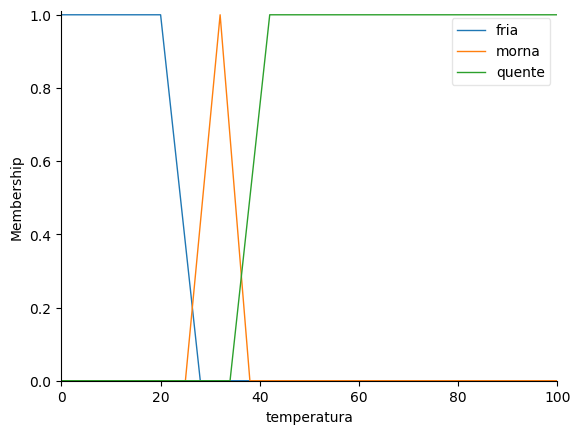

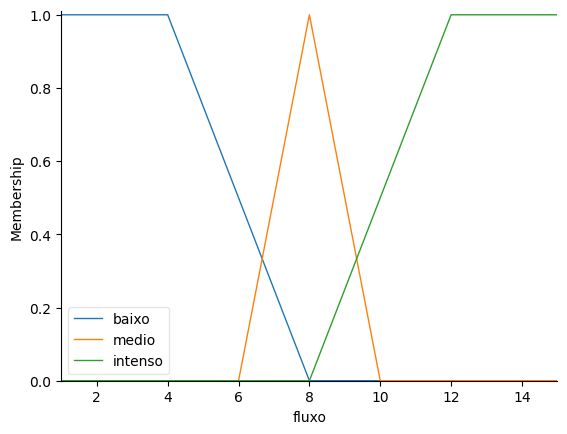

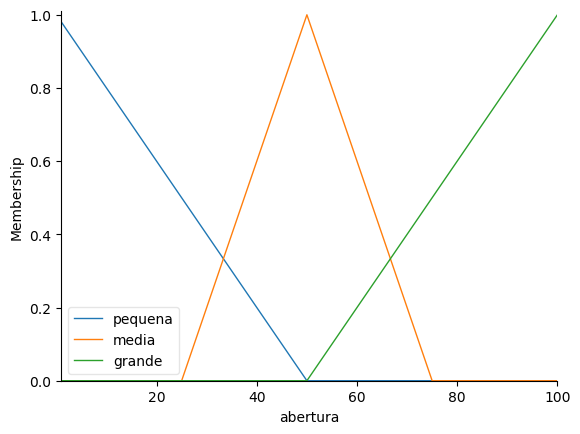

In [23]:
# Caso queira visualizar graficamente as funções,
temperatura.view()
fluxo.view()
abertura.view()

## Base de Regras

1. SE **temperatura** é fria E **fluxo de água** é intenso, ENTÃO **abertura da válvula** é grande.
2. SE **temperatura** é fria E **fluxo de água** é médio OU baixo, ENTÃO **abertura da válvula** é média.
3. SE **temperatura** é morna E **fluxo de água** é intenso, ENTÃO **abertura da válvula** é média.
4. SE **temperatura** é morna E **fluxo de água** é médio OU baixo, ENTÃO **abertura da válvula** é pequena.
5. SE **temperatura** é quente E **fluxo de água** é baixo, ENTÃO **abertura da válvula** é pequena.
6. SE **temperatura** é quente E **fluxo de água** é intenso OU médio, ENTÃO **abertura da válvula** é média.

In [24]:
rule1 = ctrl.Rule(temperatura['fria'] & fluxo['intenso'], abertura['grande'])
rule2 = ctrl.Rule(temperatura['fria'] & fluxo['medio'] | fluxo['baixo'], abertura['media'])
rule3 = ctrl.Rule(temperatura['morna'] & fluxo['intenso'], abertura['media'])
rule4 = ctrl.Rule(temperatura['morna'] & fluxo['medio'] | fluxo['baixo'], abertura['pequena'])
rule5 = ctrl.Rule(temperatura['quente'] & fluxo['baixo'], abertura['pequena'])
rule6 = ctrl.Rule(temperatura['quente'] & fluxo['intenso'] | fluxo['medio'], abertura['media'])

## Inferência e Defuzzificação

O Scikit-Fuzzy utiliza a inferência de Mamdani (https://pythonhosted.org/scikit-fuzzy/api/skfuzzy.control.html#skfuzzy.control.ControlSystemSimulation) e o método centroide de defuzzificação por padrão. 

No processo de defuzzificação, obtemos um número real "crisp" através do cálculo do centroide do conjunto fuzzy. Neste caso, recebemos a variável dependente "Abertura da válvula do chuveiro" como número real.

In [30]:
sistema_temp_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])
sistema_temp = ctrl.ControlSystemSimulation(sistema_temp_ctrl)

## Execução

Edite os parâmetros reais em `temperatura_user` e `fluxo_user` para receber o valor da abertura da válvula do chuveiro.

In [32]:
temperatura_user = 28.3
fluxo_user = 8.32

sistema_temp.input['temperatura'] = temperatura_user
sistema_temp.input['fluxo'] = fluxo_user
sistema_temp.compute()
abertura_calculada = sistema_temp.output['abertura']

print(f"Resultado: Abertura da válvula do chuveiro = {abertura_calculada:.2f}%.\n")

Resultado: Abertura da válvula do chuveiro = 37.69%.

